In [1]:
from pylab import * 
from scipy.optimize import brentq
from scipy.interpolate import PchipInterpolator
%matplotlib inline
rcParams['figure.figsize'] = 10, 6
plt.style.use('ggplot')

# Calculating CT knee point voltage

Algorithmically determine a CT's knee point voltage from interpolated data.

## Test data

Magnetisation current and voltage data obtained from testing.

In [2]:
# EAAY C196 data 2S1-2S5
i_test = 0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0
v_test = 175, 440, 800, 925, 970, 990, 1020, 1050

# Marvisfield =EA02-T03 (A496) mag curve data from old scanned test report.
# i_test = 0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0
# v_test = 150, 340, 800, 925, 975, 1000, 1020, 1040

# i_test = 0.075, .15, .2, .4, .8, 1, 2, 3, 5
# v_test = 240, 480, 490, 530, 550, 555, 570, 580, 590

# i_test = .03, .05, .1, .15, .2, .3, .4, .5, .6, .8, .9, 1, 1.5, 2, 2.5, 3
# v_test = 95, 194, 370, 420, 442, 465, 475, 478, 482, 489, 492, 495, 500, 509, 511, 514

Plot test data and interpolated values.

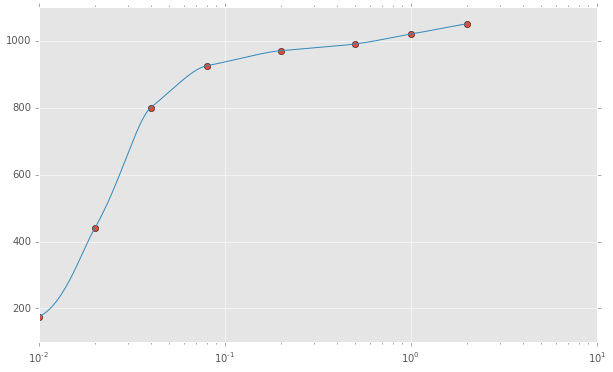

In [3]:
# Convert input tuples to numpy arrays.
i_test = np.array(i_test, dtype='float')
v_test = np.array(v_test, dtype='float')

# Create an interpolator from test data that returns interpolated voltages. 
interp_v = PchipInterpolator(i_test, v_test)
# Log-spaced  current values between first and last test data points.
i = logspace(log10(i_test[0]), log10(i_test[-1]), num=500)
v = interp_v(i)

# Plot the test data points and interpolated values.
plot(i_test, v_test, 'o')
plot(i, v)
xscale('log')

## Finding the knee point

The graph of $V(I)$ above shows the relationship between RMS voltage ($V$) and RMS magnetising current ($I$) from interpolated test data.

According to the IEC definition, the knee point voltage is the point at which a 10&nbsp;% increase in voltage requires a 50&nbsp;% increase in magnetising current.  Thus, the knee point voltage occurs at $I$ where $\frac{V(1.5 I)}{V(I)} = 1.1$. 

The knee point can be found by solving the roots of the equation $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$. This will find the knee point voltage, but could also possibly find the ankle point voltage. The ankle point voltage needs to be discarded as a valid result.

Observing the graph of $V(I)$, it can be seen that the knee point voltage occurs in a region where the rate of change of voltage is decreasing. That is, where the second derivative of $V(I)$ is less than zero ($\frac{d^2V}{dI^2} < 0$). The ankle point voltage occurs in a region where the rate of change of voltage is increasing. That is, where the second derivative of $V(I)$ is greater than zero ($\frac{d^2V}{dI^2} > 0$). 

The knee point can be found by solving the roots of $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$ for values of $I$ that satisfy $\frac{d^2V}{dI^2} < 0$.

### Knee point equation 

Plot the equation $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$.

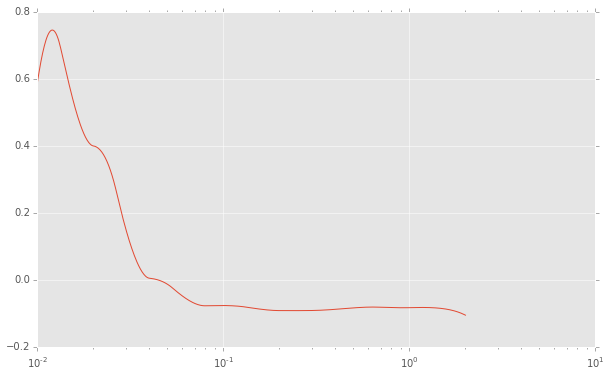

In [4]:
# Define and plot the knee point equation.
knee_point_eq = lambda i: interp_v(1.5 * i) / interp_v(i) - 1.1
knee_point_eq_vals = knee_point_eq(i)
plot(i, knee_point_eq_vals)
xscale('log')

### Second derivative of $V(I)$ 

Plot $\frac{d^2V}{dI^2}$.

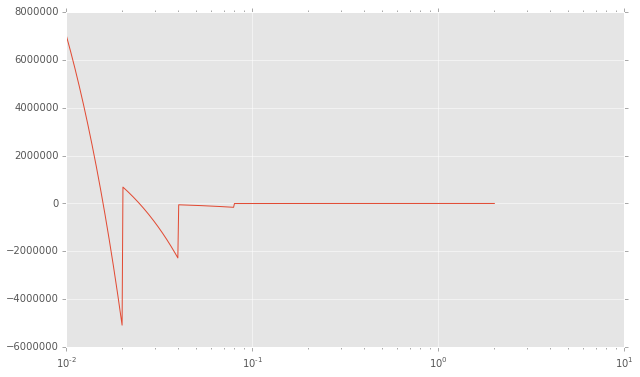

In [5]:
# Create a function that returns the second dervative of interpolated values.
d2_interp_v = interp_v.derivative(2)
d2_v = d2_interp_v(i)
plot(i, d2_v)
xscale('log')

### Valid knee point regions

Shade regions of $V(I)$ where $\frac{d^2V}{dI^2} < 0$.

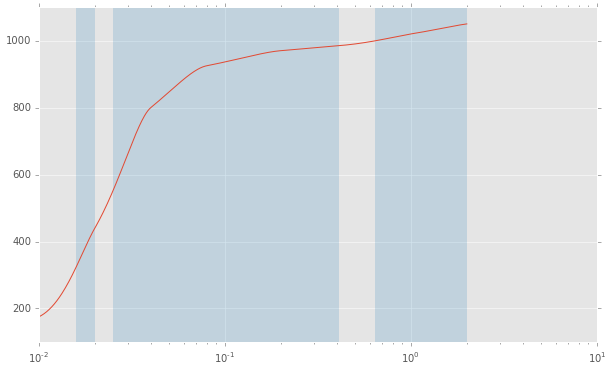

In [6]:
# Mask (mark invalid) values greater than or equal to 0.  
masked_array = ma.masked_greater_equal(d2_v, 0)
# Obtain indices of unmasked contiguous values.
slices = ma.flatnotmasked_contiguous(masked_array)
for slice in slices:
    axvspan(i[slice][0], i[slice][-1], alpha=0.2, linewidth=0)
plot(i, v)
xscale('log')

### Calculate the knee point

In [7]:
# Ranges of i where the second derivative is negative.
valid_i_ranges = (i[slice] for slice in slices)
# Intervals (start and end points) of valid ranges.
intervals = ((i_range[0], i_range[-1]) for i_range in valid_i_ranges)
# Sign changing intervals of the knee point equation. 
sign_changing_intervals = (
    (start, end) for start, end in intervals 
    if sign(knee_point_eq(start)) != sign(knee_point_eq(end))
)
# Find zeros of the knee point equation in each interval.
zeros = [brentq(knee_point_eq, start, end) for start, end in sign_changing_intervals]

# Plot if there is one and only one zero (knee point).
if len(zeros) == 1:
    i_k = zeros[0]
    v_k = np.asscalar(interp_v(i_k))

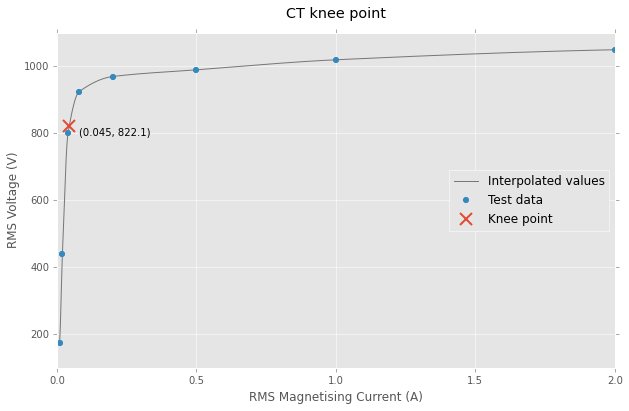

In [8]:
red, blue, purple, grey, orange, green, pink = rcParams['axes.color_cycle']
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)
axes.plot(i, v, color=grey, label='Interpolated values')
axes.plot(i_test, v_test, color=blue, marker='o', markeredgewidth=0, linewidth=0, label='Test data')
axes.plot(i_k, v_k, color=red, marker='x', markersize=12, markeredgewidth=2, linewidth=0, label='Knee point')
axes.annotate('({:.3f}, {:0.1f})'.format(i_k, v_k), (i_k, v_k), xytext=(10, -10), textcoords='offset points')
axes.set_title('CT knee point', y=1.03)
axes.set_xlabel('RMS Magnetising Current (A)')
axes.set_ylabel('RMS Voltage (V)')
axes.legend(loc='right', numpoints=1)

<sub>Brodie Blackburn, 2015</sub>